Разберёмся с ансамблями алгоритмов и со случайным лесом. Рассмотрим данные о сотрудниках компании, где указывается, ушёл сотрудник или нет.

Сделаем базовую предобработку данных: удалим признак, который отвечает за идентификатор пользователя, как нерепрезентативный признак.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.random.seed(42)

df = pd.read_csv('HR-dataset.csv')
df.tail()

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
14994,15995,0.40,0.57,2,151,3,0,1,0,support,low
14995,15996,0.37,0.48,2,160,3,0,1,0,support,low
14996,15997,0.37,0.53,2,143,3,0,1,0,support,low
14997,15998,0.11,0.96,6,280,4,0,1,0,support,low
14998,15999,0.37,0.52,2,158,3,0,1,0,support,low


In [2]:
target = 'left'
features = df.columns.drop(target)
features = features.drop('empid') #удалим индентификатор пользователя как нерепрезентативный признак

X, y = df[features].copy(), df[target]
X

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,0,sales,low
1,0.80,0.86,5,262,6,0,0,sales,medium
2,0.11,0.88,7,272,4,0,0,sales,medium
3,0.72,0.87,5,223,5,0,0,sales,low
4,0.37,0.52,2,159,3,0,0,sales,low
...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low
14995,0.37,0.48,2,160,3,0,0,support,low
14996,0.37,0.53,2,143,3,0,0,support,low
14997,0.11,0.96,6,280,4,0,0,support,low


In [3]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

Заменим идентификатор отдела, к которому относился сотрудник, на количество людей в отделе, а зарплату — на ординальную категорию. Масштабируем признаки для последующего сравнения результатов:

In [4]:
salary_ordinals = {'low': 0, 'medium': 1, 'high': 2}

X['dept'] = X['dept'].apply(X['dept'].value_counts().get)
X['salary'] = X['salary'].apply(salary_ordinals.get)

# так тоже можно
#X['dept'] = X['dept'].map(X['dept'].value_counts())
#X['salary'] = X['salary'].map(salary_ordinals)

In [5]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)
X

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,1.370267,-0.933368
1,0.752814,0.840707,0.971113,1.220423,1.713436,-0.411165,-0.147412,1.370267,0.636092
2,-2.022479,0.957554,2.593763,1.420657,0.343655,-0.411165,-0.147412,1.370267,0.636092
3,0.431041,0.899131,0.971113,0.439508,1.028546,-0.411165,-0.147412,1.370267,-0.933368
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,1.370267,-0.933368
...,...,...,...,...,...,...,...,...,...
14994,-0.856051,-0.853580,-1.462863,-1.002181,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14995,-0.976716,-1.379394,-1.462863,-0.821970,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14996,-0.976716,-1.087275,-1.462863,-1.162368,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14997,-2.022479,1.424944,1.782438,1.580845,0.343655,-0.411165,-0.147412,-0.064033,-0.933368


В дальнейшем будем оценивать качество модели на кросс-валидации на пяти фолдах при помощи точности (accuracy).

In [6]:
def estimate_accuracy(clf, X, y):
    return cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()

Посмотрим на то, как работает бэггинг над решающими деревьями.  

Бэггинг (bagging, сокр. от bootstrap aggregating)  — метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решения посредством голосования среди всех алгоритмов (возвращается самый частый ответ).

In [7]:
# Посмотрим на точность одного дерева:
tree = DecisionTreeClassifier(max_depth=30)
print("Decision tree:", estimate_accuracy(tree, X, y))

Decision tree: 0.9731310659108592


Проведём бэггинг: для этого достаточно обернуть исходный классификатор в BaggingClassifier.

In [21]:
bagging_trees = BaggingClassifier(tree)
print("Bagging trees:", estimate_accuracy(bagging_trees, X, y))

Bagging trees: 0.9887329109703235


Композиция отдельных деревьев показывает себя лучше, чем одно дерево. Структура дерева серьёзно зависит от обучающей выборки. Это значит, что если немного изменить обучающую выборку, то дерево сильно изменится. Бэггинг идеально подходит в этом случае, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различны.

In [14]:
# Увеличить различность построенных деревьев можно, указав параметры max_features и max_depth.
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=30)
print("Random Tree:", estimate_accuracy(random_tree, X, y))

Random Tree: 0.9751319995554073


In [18]:
bagging_random_trees = BaggingClassifier(random_tree)
print("Bagging random trees:", estimate_accuracy(bagging_random_trees, X, y))

Bagging random trees: 0.9907328887406914


Именно так внутри и работает так называемый случайный лес (Random Forest): он обучает набор деревьев (параметр n_esimators), каждое из которых обучается на подмножестве признаков (Random Subspaces) и на подмножестве объектов (bootstrap). То есть случайный лес получается случайным по двум этим параметрам, а ответы агрегируются при помощи голосования.  

Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии — треть числа признаков.

In [29]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       n_jobs=-1,
                                       max_features='sqrt',
                                       max_depth=30)
print("Random forest:", estimate_accuracy(random_forest, X, y))

Random forest: 0.9918663109925532


Ещё одно преимущество использования бэггинга для агрегации моделей — получение оценки работы классификатора без дополнительного проведения кросс-валидации при помощи out-of-bag score. Это метод вычисления произвольной оценки качества во время обучения бэггинга. Для подсчёта требуется указать параметр oob_score = True, что имеет смысл при достаточном количестве деревьев.

In [59]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       n_jobs=-1,
                                       max_features='sqrt',
                                       max_depth=30,
                                       oob_score=True)
random_forest.fit(X,y)
random_forest.oob_score_

0.9924661644109607

In [56]:
pd.DataFrame(data=random_forest.feature_importances_, index=X.columns).sort_values(by=0, ascending=False)

,0
satisfaction_level,0.348698
time_spend_company,0.189763
number_project,0.171230
average_montly_hours,0.141799
last_evaluation,0.120587
dept,0.011914
salary,0.008500
Work_accident,0.006540
promotion_last_5years,0.000969


In [55]:
from sklearn.inspection import permutation_importance
result = permutation_importance(random_forest, X, y)
pd.DataFrame(data=result.importances_mean, index=X.columns).sort_values(by=0, ascending=False)

,0
satisfaction_level,0.219788
number_project,0.134169
average_montly_hours,0.134102
last_evaluation,0.126168
time_spend_company,0.116848
dept,0.007814
salary,0.006387
Work_accident,0.001893
promotion_last_5years,0.000200


Метод бэггинга можно применять к произвольным алгоритмам, например, к логистической регрессии. 

In [63]:
lr = LogisticRegression(solver='saga', max_iter=200)
print("LR: ", estimate_accuracy(lr, X, y))

LR:  0.7709770367900411


In [64]:
bagging_lr = BaggingClassifier(lr)
print("Bagging LR: ", estimate_accuracy(bagging_lr, X, y))

Bagging LR:  0.7709773480048905


В её случае он не так сильно повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки. Попробуем убрать часть признаков.

In [65]:
random_lr = BaggingClassifier(lr, max_features=0.5)
print("Random bagging LR: ", estimate_accuracy(random_lr, X, y))

Random bagging LR:  0.7799824385906413


В случае логистической регрессии повышение разнообразности моделей не даёт такого прироста, как с деревьями, поскольку модели сильно теряют в качестве. Случайный лес на примере нашей задачи справляется лучше.

Сравнение логистической регрессии и случайного леса:

In [99]:
def plot_predictions(clf, X, y, proba=False, point_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X,y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_std, y_std = data.std(axis=0)
        x_min, x_max = data[:,0].min() - x_std/2, data[:,0].max() + x_std/2
        y_min, y_max = data[:,1].min() - y_std/2, data[:,1].max() + y_std/2
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X,y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()][:,1]).reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10,10), facecolor='w')
    plt.pcolormesh(xx, yy, predicted, shading='auto', cmap=plt.cm.coolwarm, alpha=0.30)
    plt.scatter(X[:,0], X[:,1], c=y, s=point_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.xlim([xx.min(), xx.max()])
    plt.ylim([yy.min(), yy.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    return clf

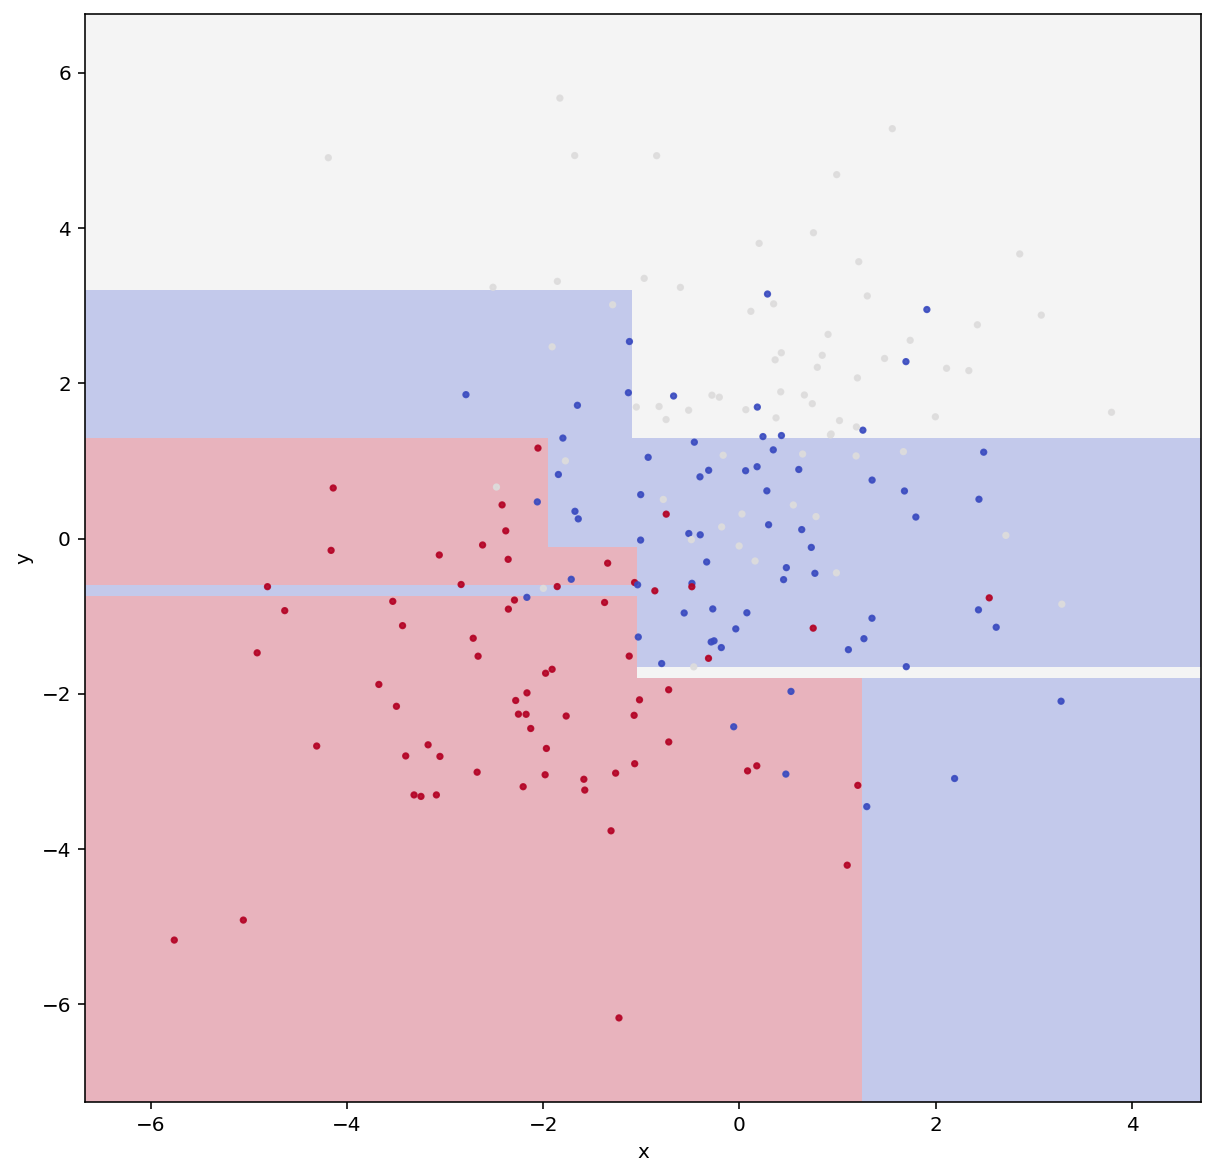

DecisionTreeClassifier(max_depth=4, random_state=1)

In [128]:
from sklearn.datasets import make_blobs
RANDOM_SEED = 1

train_data, train_labels = make_blobs(n_samples=200, centers=[(0,0),(0,2),(-2,-2)], 
                                      n_features=2,
                                      cluster_std=(1.5,1.5,1.5),
                                      random_state=RANDOM_SEED)

tree = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_SEED)
tree.fit(train_data, train_labels)
plot_predictions(tree, train_data, train_labels)

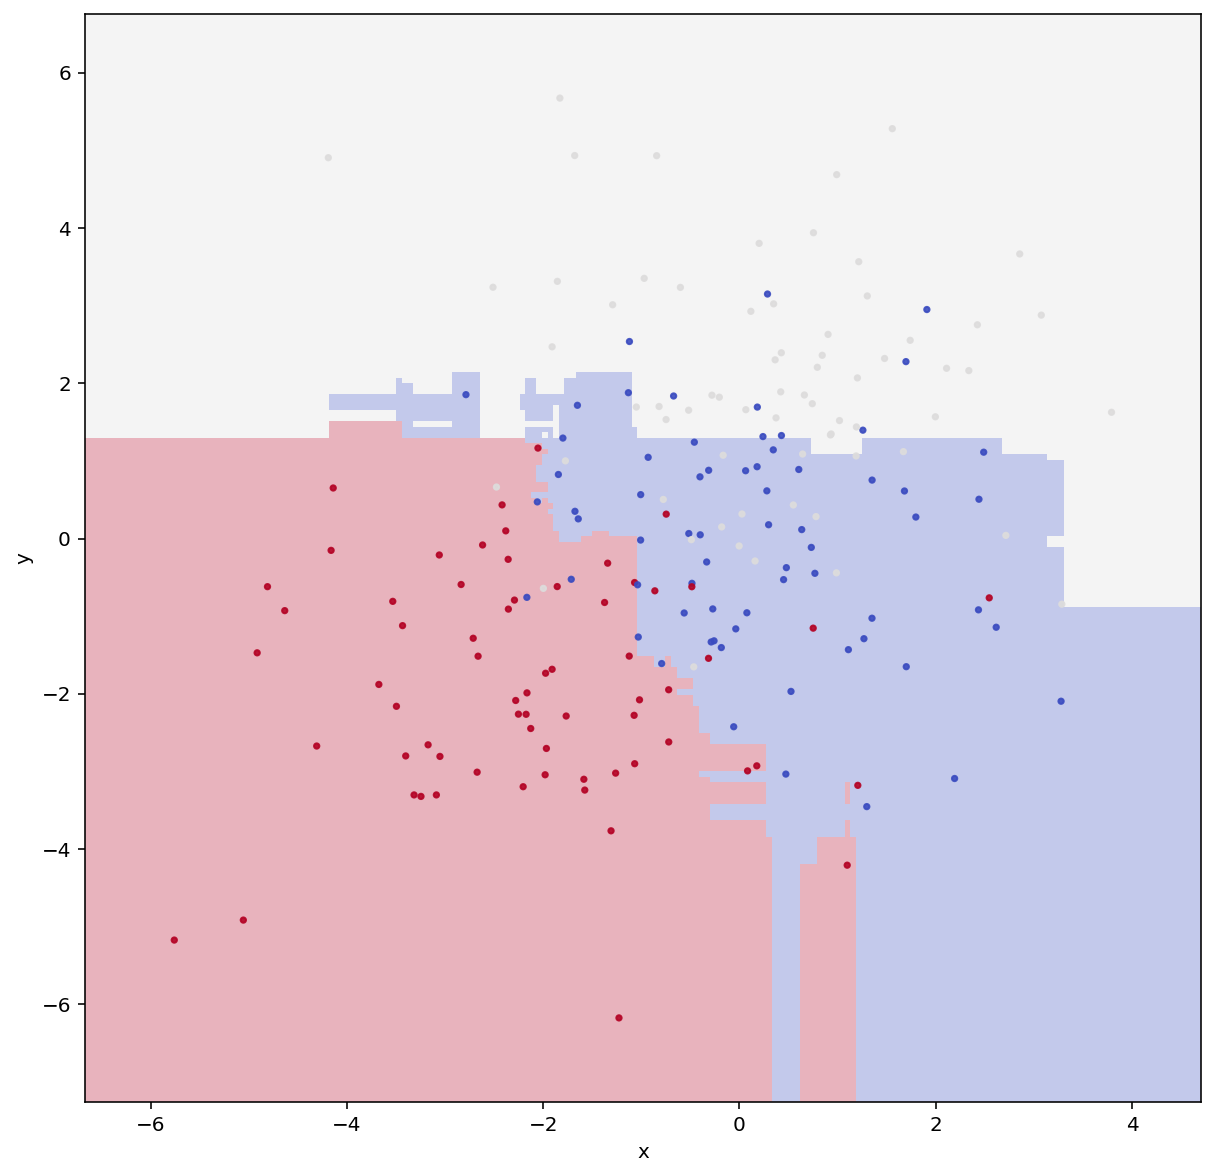

RandomForestClassifier(max_depth=4, random_state=1)

In [129]:
rf = RandomForestClassifier(max_depth=4, random_state=RANDOM_SEED)
rf.fit(train_data, train_labels)
plot_predictions(rf, train_data, train_labels)

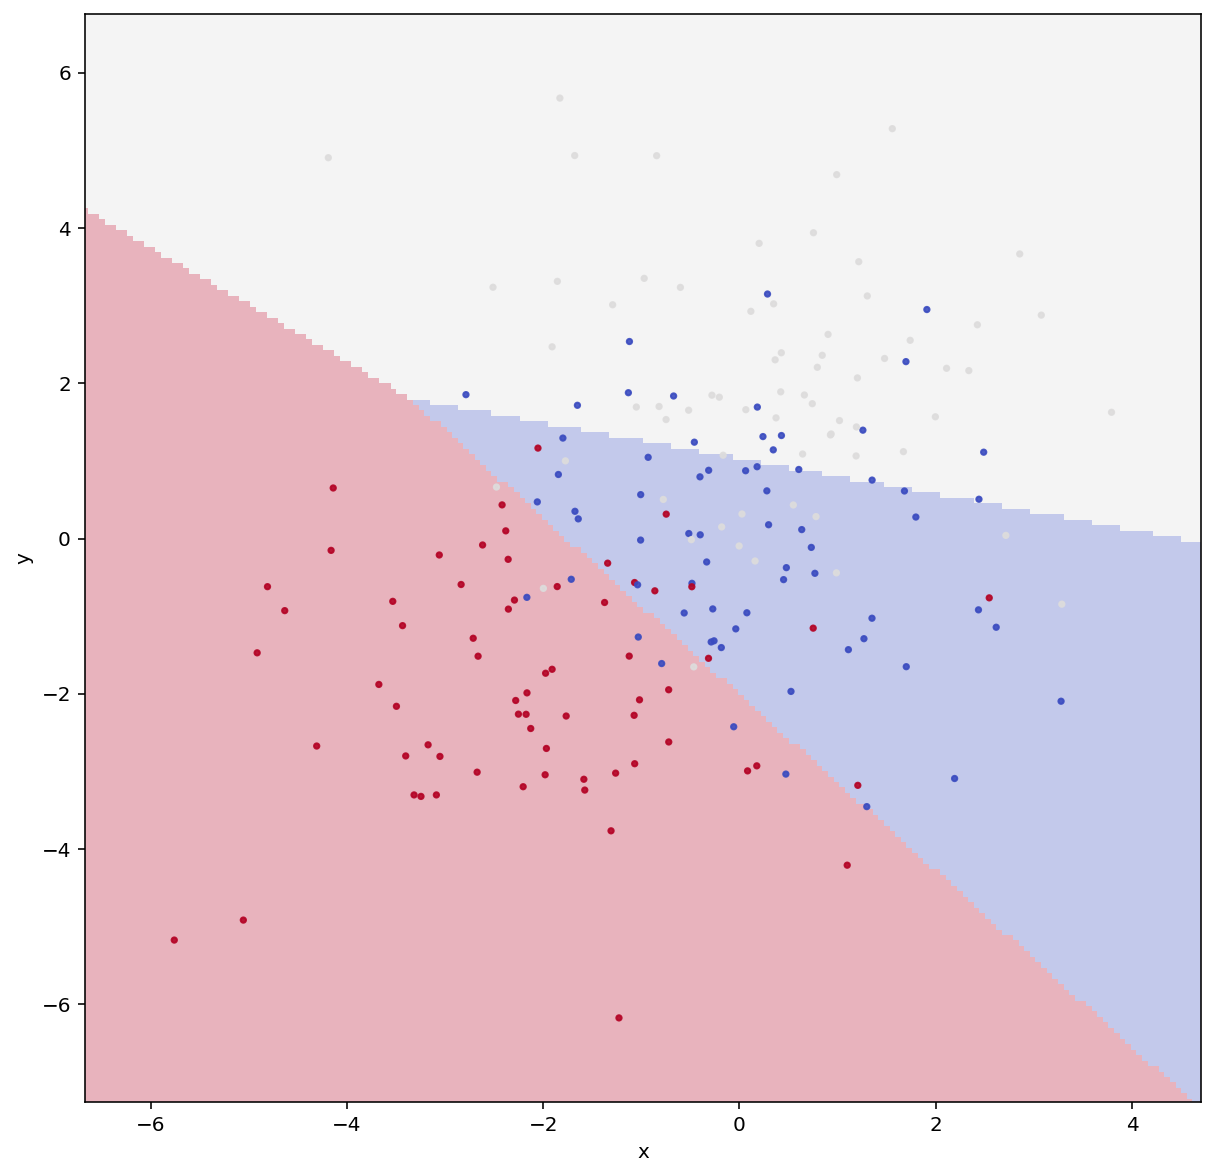

LogisticRegression(random_state=1)

In [130]:
lr = LogisticRegression(random_state=RANDOM_SEED)
lr.fit(train_data, train_labels)
plot_predictions(lr, train_data, train_labels)

In [136]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target
X,y

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

In [140]:
print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [156]:
from sklearn.model_selection import cross_val_score

tree = DecisionTreeClassifier()
cross_val_score(tree, X, y, cv=10).mean()

0.8291495965238982

In [164]:
bagging_tree = BaggingClassifier(base_estimator=tree, n_estimators=100, n_jobs=-1)
cross_val_score(bagging_tree, X, y, cv=10).mean()

0.9253910614525139

In [186]:
sqrt_bagging_tree = BaggingClassifier(base_estimator=tree,
                                        n_estimators=100,
                                        n_jobs=-1,
                                        max_features=int(np.sqrt(X.shape[1])))
cross_val_score(sqrt_bagging_tree, X, y, cv=10).mean()

0.936011793916822

In [187]:
random_bagging_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'),
                                        n_estimators=100,
                                        n_jobs=-1)
cross_val_score(random_bagging_tree, X, y, cv=10).mean()

0.9499162011173183

In [188]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       n_jobs=-1,
                                       max_features='sqrt')
cross_val_score(random_forest, X, y, cv=10).mean()

0.9465518311607696

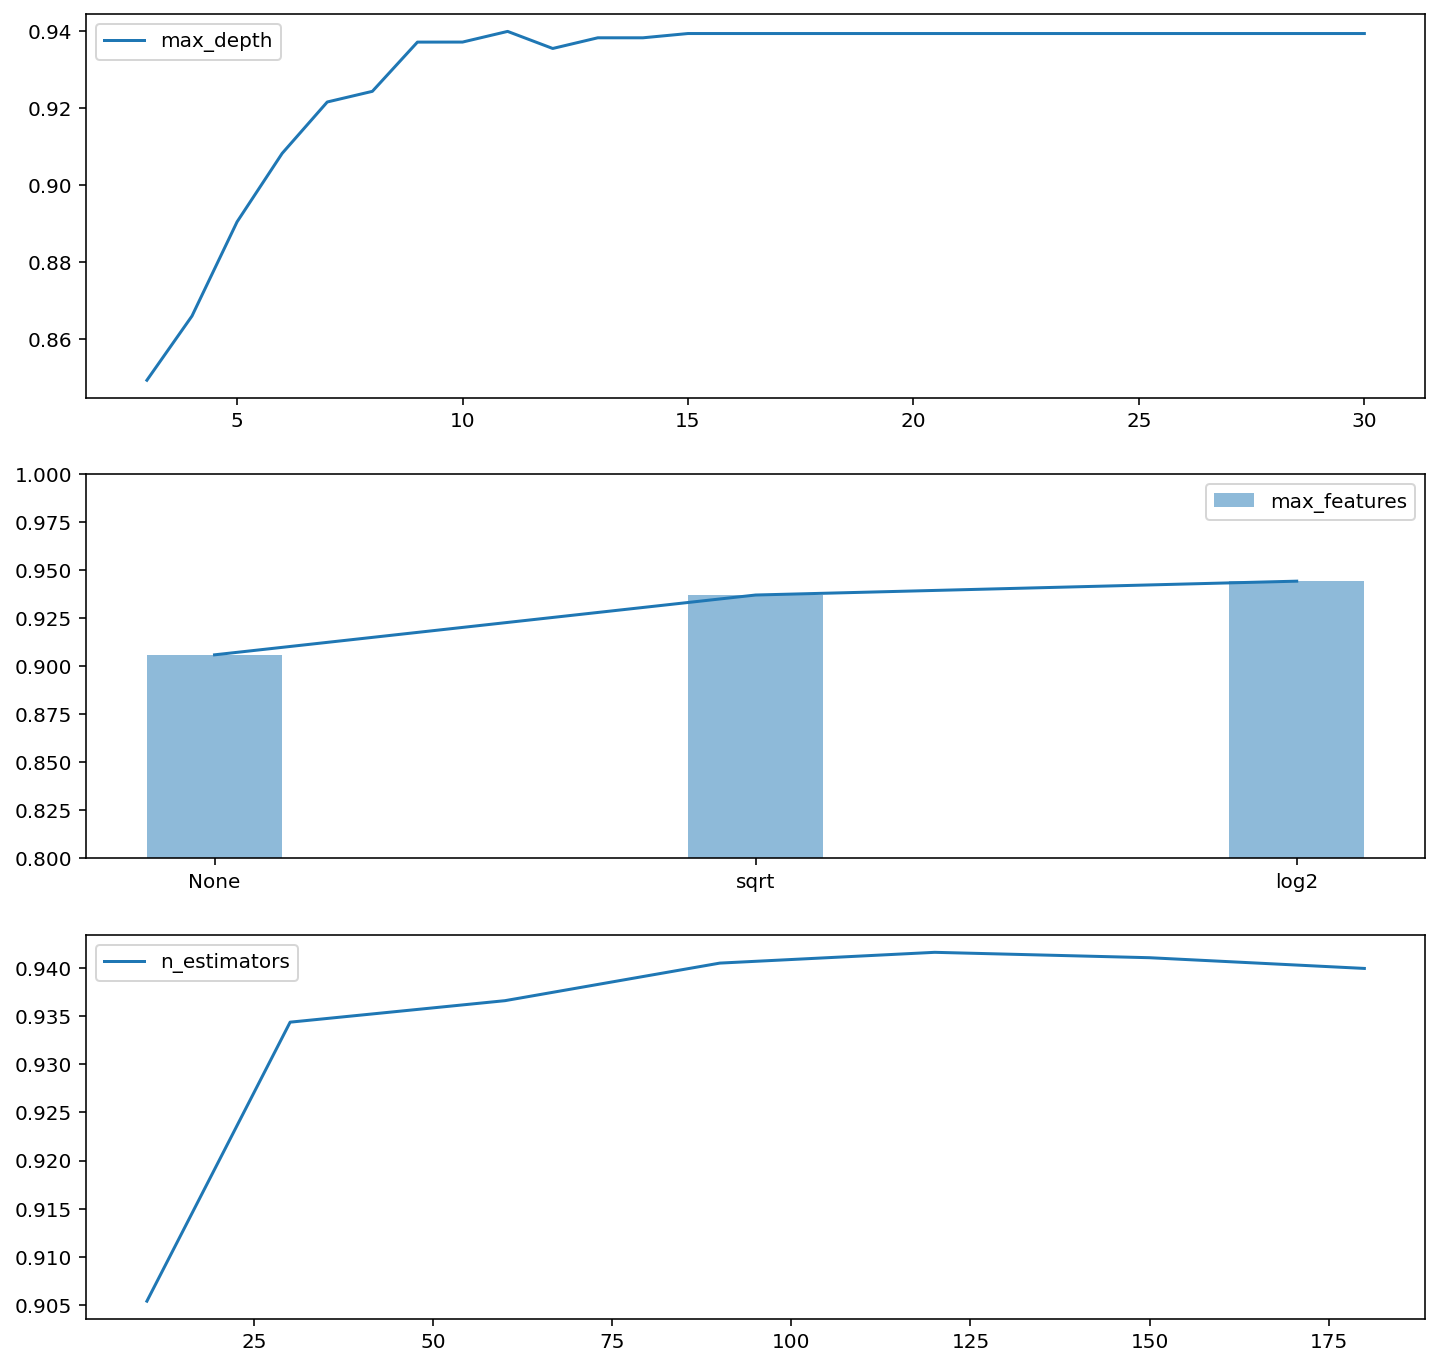

In [244]:
max_depth_list = np.arange(3,31)
max_features_list = [None, 'sqrt', 'log2']
n_estimators_list = [10,30,60,90,120,150,180]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12), facecolor='w')

# different depths of trees
score=[]
for m_depth in max_depth_list:
    rf = RandomForestClassifier(max_depth=m_depth, n_jobs=-1, random_state=42)
    score.append(cross_val_score(rf, X, y, cv=5).mean())
axes[0].plot(max_depth_list, score, label='max_depth')
axes[0].legend()

# different types of max_features
score=[]
for m_features in max_features_list:
    rf = RandomForestClassifier(max_depth=10, max_features=m_features, n_jobs=-1, random_state=42)
    score.append(cross_val_score(rf, X, y, cv=5).mean())
axes[1].bar([str(x) for x in max_features_list], score, width=0.25, label='max_features', alpha=0.5)
axes[1].plot(score)
axes[1].set_ylim(0.8,1)
axes[1].legend()

# different count of trees in a forest
score=[]
for n_est in n_estimators_list:
    rf = RandomForestClassifier(n_estimators = n_est,
                                max_depth=10,
                                max_features='log2',
                                n_jobs=-1,
                                random_state=42)
    score.append(cross_val_score(rf, X, y, cv=5).mean())
axes[2].plot(n_estimators_list, score, label='n_estimators')
axes[2].legend()

plt.show()

In [245]:
rf_best = RandomForestClassifier(n_estimators=124,                                       
                                 max_features='log2',
                                 max_depth=11,
                                 n_jobs=-1,
                                 random_state=42)
cross_val_score(rf_best, X, y, cv=10).mean()

0.9499193047796399

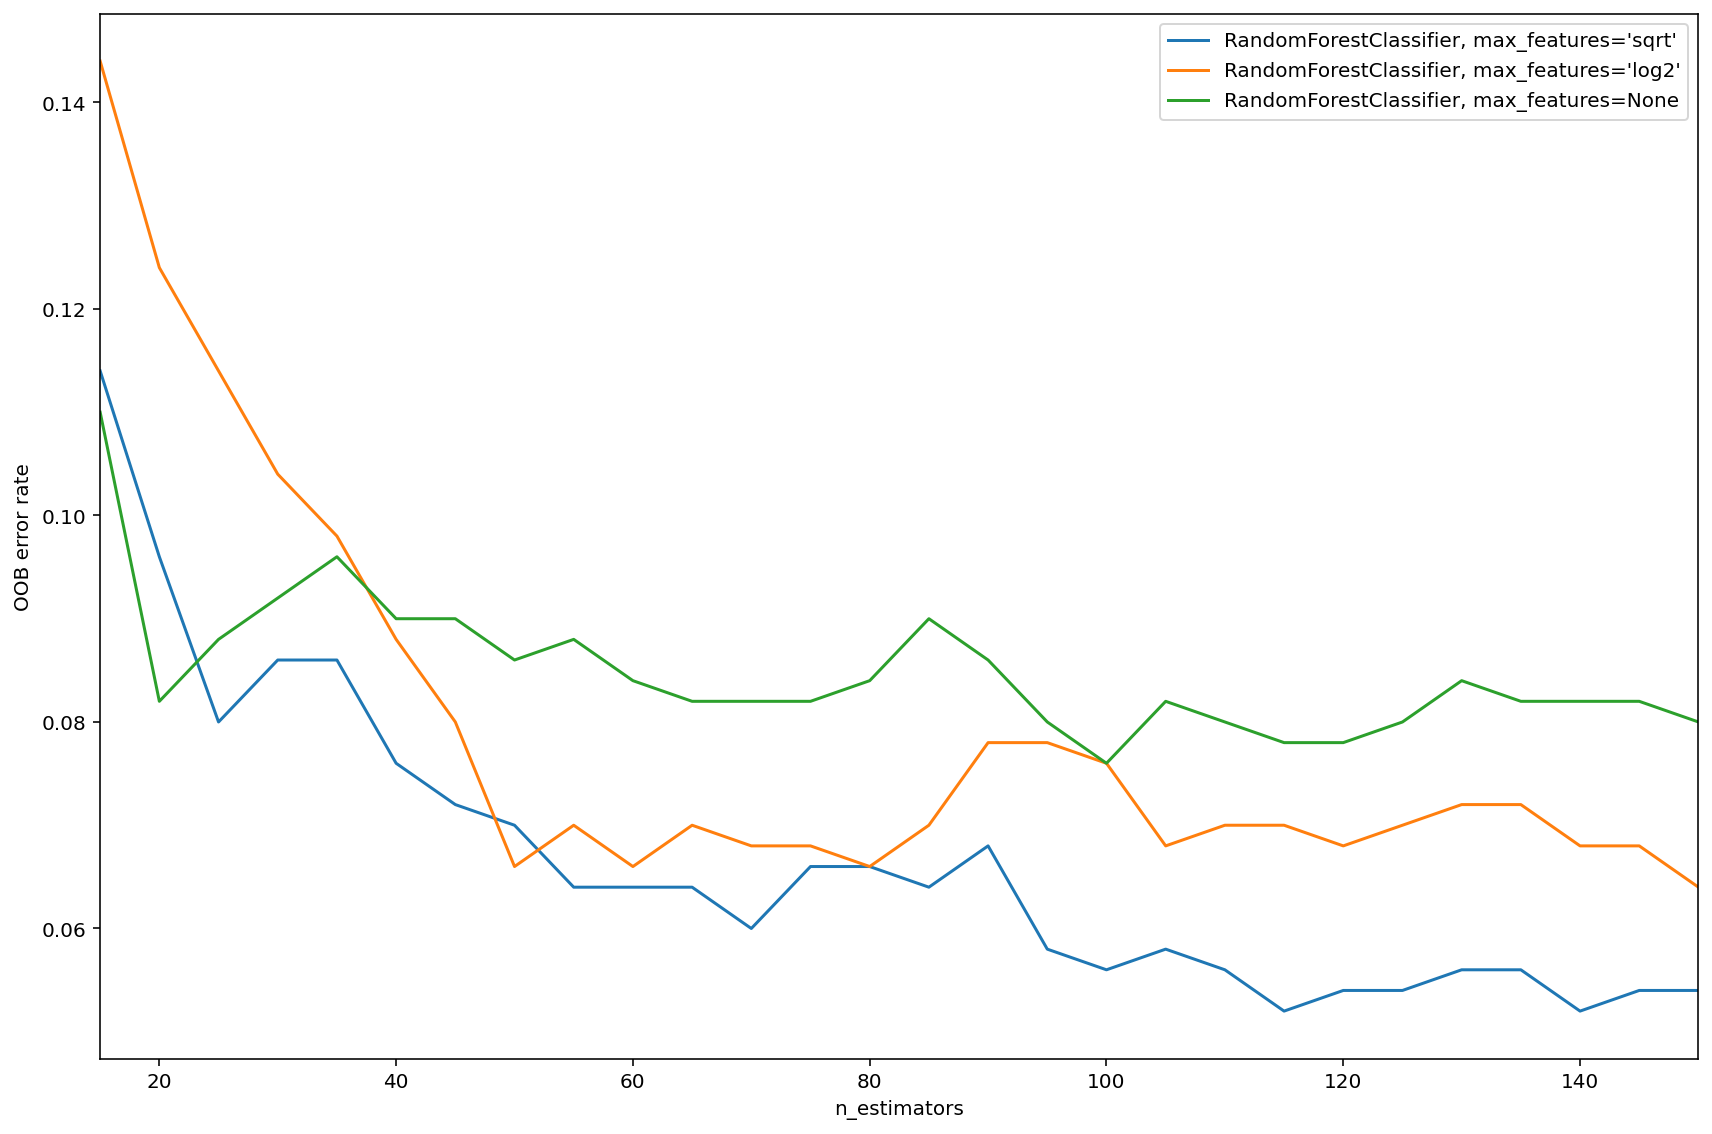

In [253]:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(
    n_samples=500,
    n_features=25,
    n_clusters_per_class=1,
    n_informative=15,
    random_state=RANDOM_STATE,
)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

plt.figure(figsize=(12,8), facecolor='w')
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()